# Model 1: Solution and Comparative Statics

In [1]:
import matplotlib.pyplot as plt
from pathlib import Path
from matplotlib.collections import LineCollection
import matplotlib as mpl
import numpy as np
from scipy import optimize as opt
from scipy import integrate as intg
from scipy.stats import beta
from scipy.stats import cumfreq, beta  

%matplotlib inline
plt.style.use('../notebook.mplstyle')

## Exogenous model parameters

In [2]:
# Setting exogenous parameters
def reset_exog_params():
    global b0, b_vals, δ, u , ρ, α, β
    b0 = 20
    b_vals = range(1,b0+1)
    δ = 0.95
    u = lambda x : x
    ρ = 1
    α,β = (1,1) 

## Swiping Optimality Conditions 

In [3]:
# Initial condition equation
def initial_condition(x):
    return (u(x) 
            - δ * u(x) * beta.cdf(x,α,β) 
            - δ * intg.quad(lambda t: u(t) * beta.pdf(t,α,β), x, 1)[0])

# Recurrence relation 
def phi(x):
    return (u(x) 
            - δ * u(x) * beta.cdf(x,α,β) 
            - δ * u(θ_prev)*(1-beta.cdf(θ_prev,α,β)) 
            - δ * intg.quad(lambda t : u(t) * beta.pdf(t,α,β), x, θ_prev)[0])

## Computing $\left\{\theta^*_b\right\}^{b_0}_{b=1}$

In [4]:
def compute_θ1():
    return opt.root_scalar(initial_condition, bracket=[0,1], method='brentq').root

def compute_θb():
    return opt.root_scalar(phi, bracket=[0,1], method='brentq').root
    
def compute_θ_vals(b0):
    global θ_prev
    θ_vals = [compute_θ1()]
    for i in range(b0-1):
        θ_prev = θ_vals[i]
        θ_vals.append(compute_θb())
    return θ_vals    

[0.7239474737685385, 0.6234017591118854, 0.5527721226626521, 0.49761264659894994, 0.45227643917211763, 0.4138559218635783, 0.38062107208637114, 0.35144437331633377, 0.325543109845931, 0.30234807408168585, 0.2814302753081928, 0.26245711071842737, 0.24516470375864582, 0.2293396711473446, 0.21480666677029975, 0.2014196126630609, 0.189055365729076, 0.177609041609025, 0.1669904950762235, 0.1571216257416069]


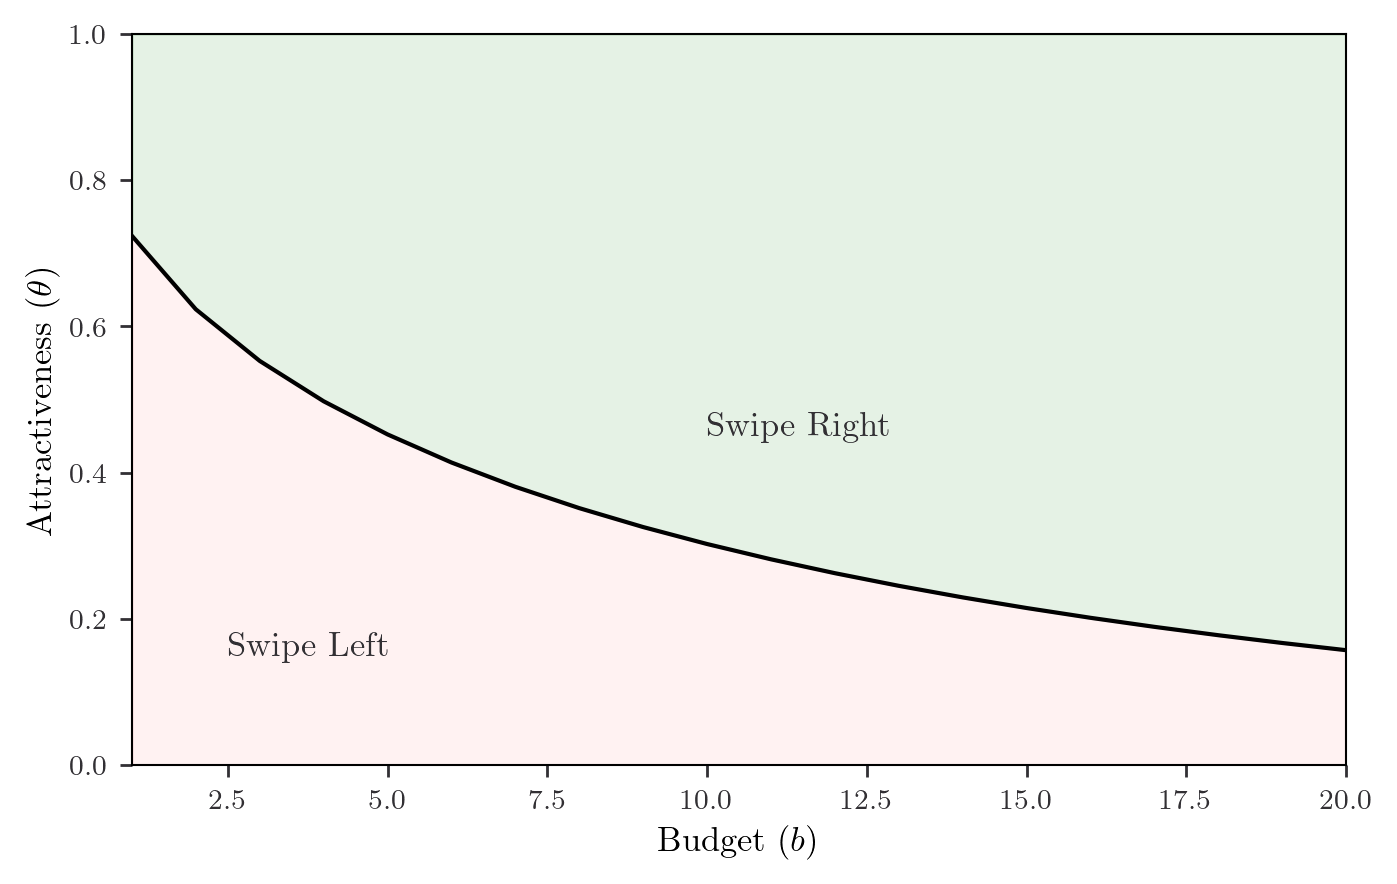

In [5]:
# Resetting exogenous parameters
reset_exog_params()
θ_vals = compute_θ_vals(b0)
print(θ_vals)

# Plotting swiping rule    
fig, ax = plt.subplots()
ax.set_xlim(1,b0)
ax.set_ylim(0,1)
ax.plot(b_vals, θ_vals, color='k')
ax.fill_between(b_vals, 0, θ_vals, color='red', alpha=0.05)
ax.fill_between(b_vals, θ_vals, 1, color='green', alpha=0.1)
ax.text(2.5, 0.15, 'Swipe Left')
ax.text(10, 0.45, 'Swipe Right')
ax.set(xlabel=r'Budget ($b$)', ylabel=r'Attractiveness ($\theta$)')
#fig.suptitle('Figure 1: Optimal Swiping Rule')
#plt.savefig('../../figures/swiping-rule.png', bbox_inches='tight')
plt.show()

## Computing value function $V(\theta,b)$

Given the value function

$$
 V(\theta, b)=\begin{cases}\rho u(\theta) +\delta \,\mathbb{E}_{\theta'}\left[V(\theta', b-1)\right],\quad \theta>\theta^*_b \\\\ \delta \,\mathbb{E}_{\theta'}\left[V(\theta', b)\right],\quad \theta\leq\theta^*_b\end{cases}
$$

Define the continutation value at budget $b$ as:

$$
 K_b := \mathbb{E}_{\theta'}\left[V(\theta', b)\right]
$$

In [6]:
# Resetting exogenous parameters
reset_exog_params()
θ_vals = compute_θ_vals(b0)

K_vals = [0]
for i in b_vals:
    K = ((δ / (1 - δ * beta.cdf(θ_vals[i-1],α,β)))
         * intg.quad(lambda t : (ρ * u(t) + K_vals[i-1]) * beta.pdf(t,α,β), θ_vals[i-1], 1)[0])
    K_vals.append(K)

def V(θ, b):
    if b==0:
        return 0
    elif θ > θ_vals[b-1]:
        return ρ * u(θ) + K_vals[b-1]
    return K_vals[b]
    
V = np.vectorize(V)

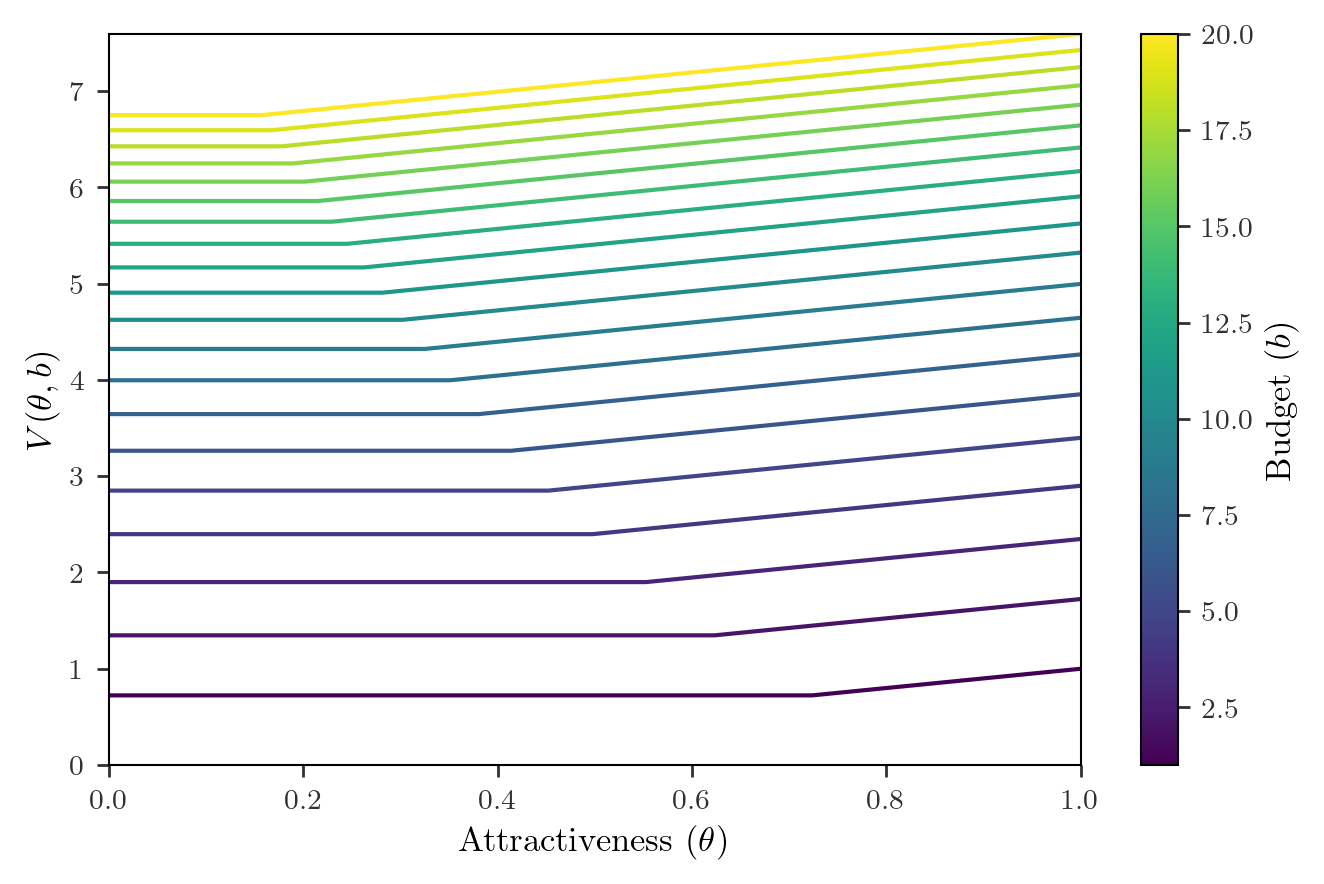

In [7]:
# Plotting value function in (θ, V) space
θ = np.linspace(0, 1, 1000)

fig, ax = plt.subplots()
ax.set_xlim(0,1)
ax.set_ylim(0,max(V(θ,b0)))
line_segments = LineCollection([np.column_stack([θ, V(θ,b)]) 
                                for b in b_vals])
line_segments.set_array(np.array(b_vals))
ax.add_collection(line_segments)
axcb = fig.colorbar(line_segments)
axcb.set_label(r'Budget ($b$)')
ax.set(xlabel=r'Attractiveness ($\theta$)', ylabel=r'$V(\theta,b)$') 
#plt.savefig('../../figures/value-theta-space.png', bbox_inches='tight')
plt.show()

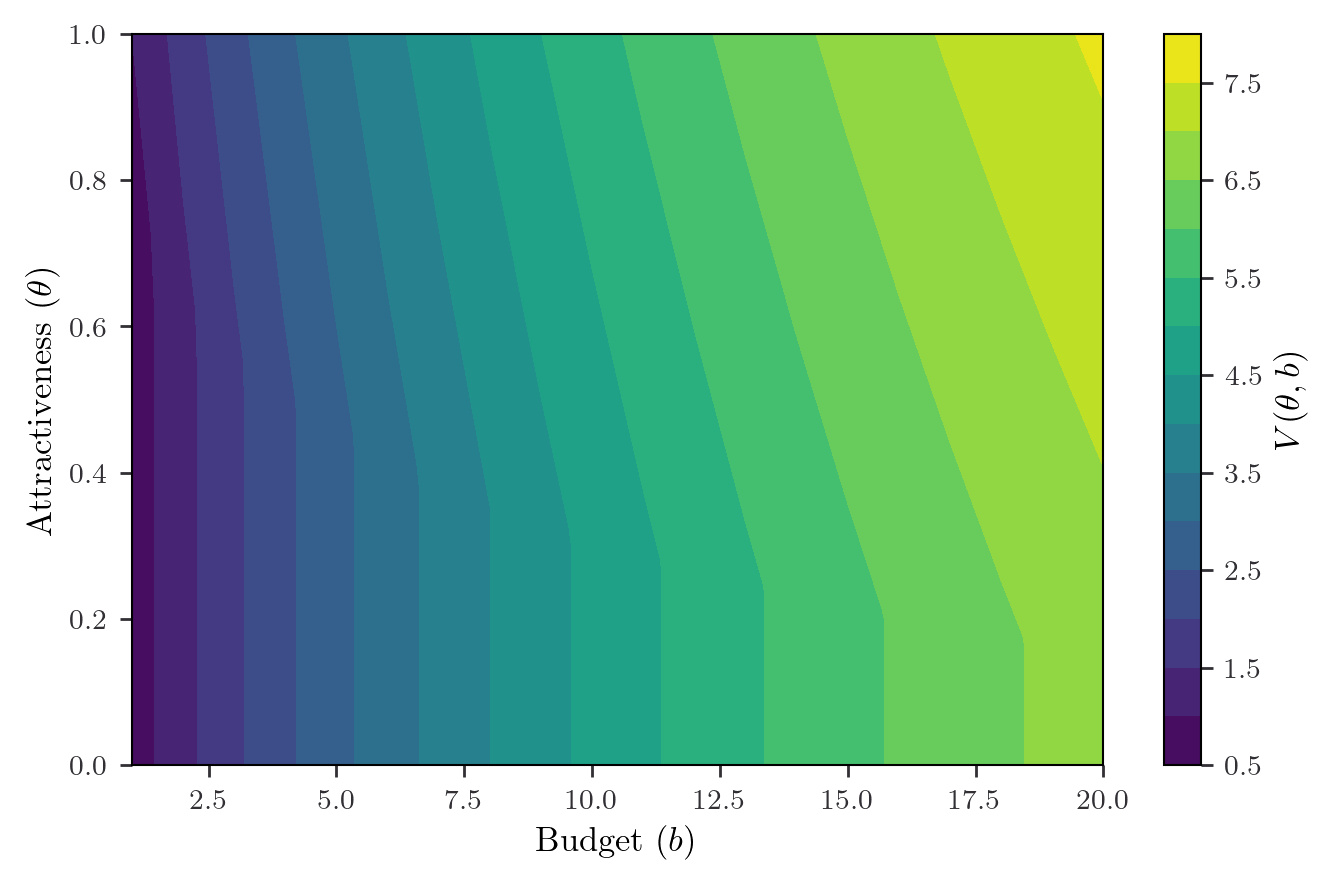

In [8]:
# Plotting value function in (θ, b) space
θ = np.linspace(0, 1, 1000)

bs, θs = np.meshgrid(b_vals, θ)
vs = V(θs, bs)

fig, ax = plt.subplots()
csf = ax.contourf(b_vals, θ, vs, levels=int(b0/1.2))
axcb = fig.colorbar(csf)
axcb.set_label(r'$V(\theta,b)$')
ax.set(xlabel=r'Budget ($b$)', ylabel=r'Attractiveness ($\theta$)') 
#plt.savefig('../../figures/value-b-space.png', bbox_inches='tight')
plt.show()

## Comparative statics on discount factor $\delta$

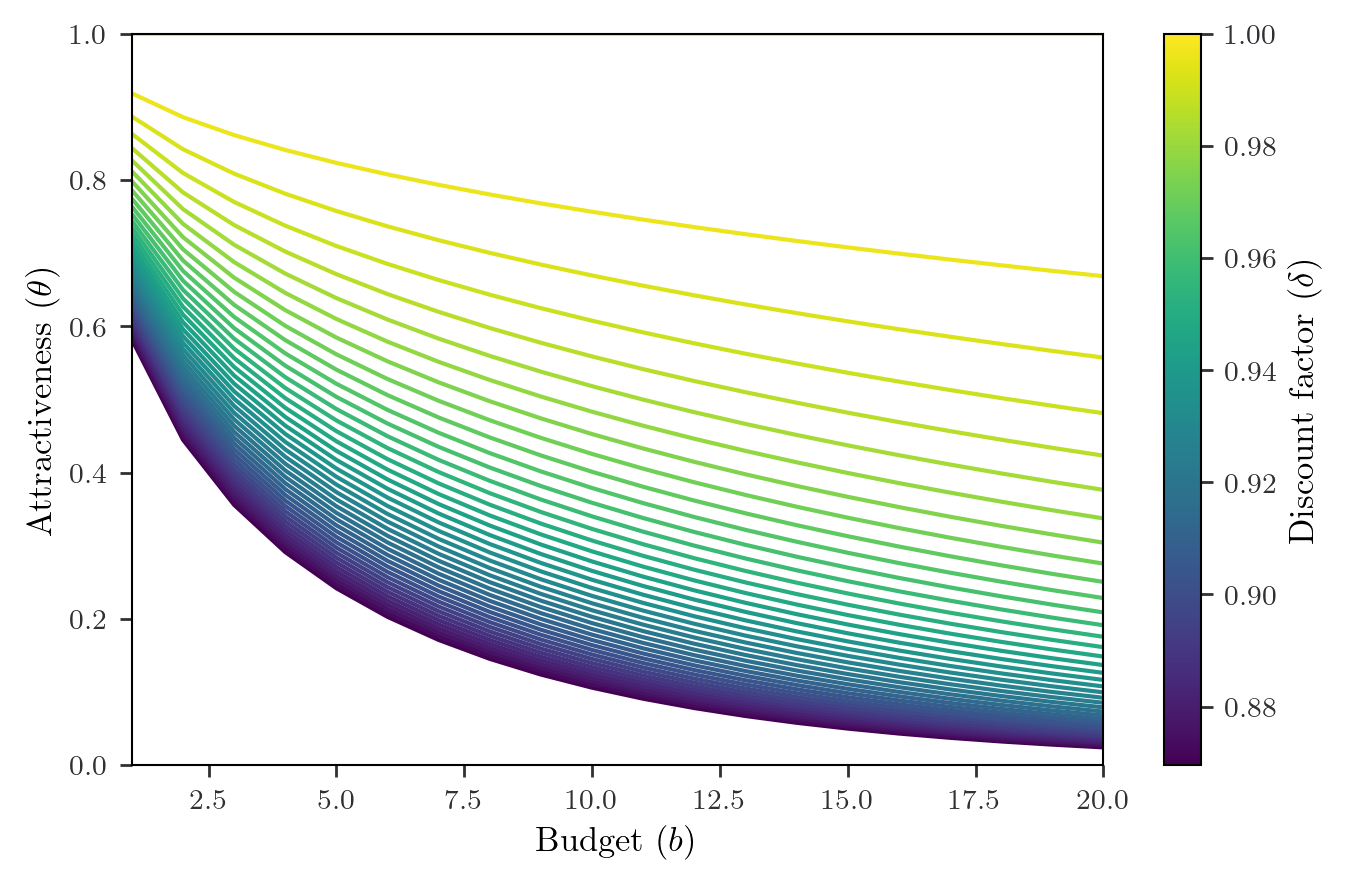

In [9]:
# Resetting exogenous parameters
reset_exog_params()

δ_vals = np.logspace(-1, 0, 40, base=1.15)
swiping_rules = []

for d in δ_vals:
    δ = d
    θ_vals = compute_θ_vals(b0)
    swiping_rules.append(θ_vals) 

# Plotting swiping rules
fig, ax = plt.subplots()
ax.set_xlim(1,b0)
ax.set_ylim(0,1)
line_segments = LineCollection([np.column_stack([b_vals, θ_vals]) 
                                for θ_vals in swiping_rules])
line_segments.set_array(np.array(δ_vals))
ax.add_collection(line_segments)
axcb = fig.colorbar(line_segments)
axcb.set_label(r'Discount factor ($\delta$)')   
ax.set(xlabel=r'Budget ($b$)', ylabel=r'Attractiveness ($\theta$)')
#plt.savefig('../../figures/discount-cs.png', bbox_inches='tight')
plt.show()    

## Comparative statics on absolute risk aversion
Consider an agent with exponential utility and a coefficient of absolute risk aversion $r$

$$
 u(\theta) \,=\, \begin{cases} \left(1-e^{-r\theta}\right)/r & r\neq0 \\ \theta & r=0\end{cases}
$$

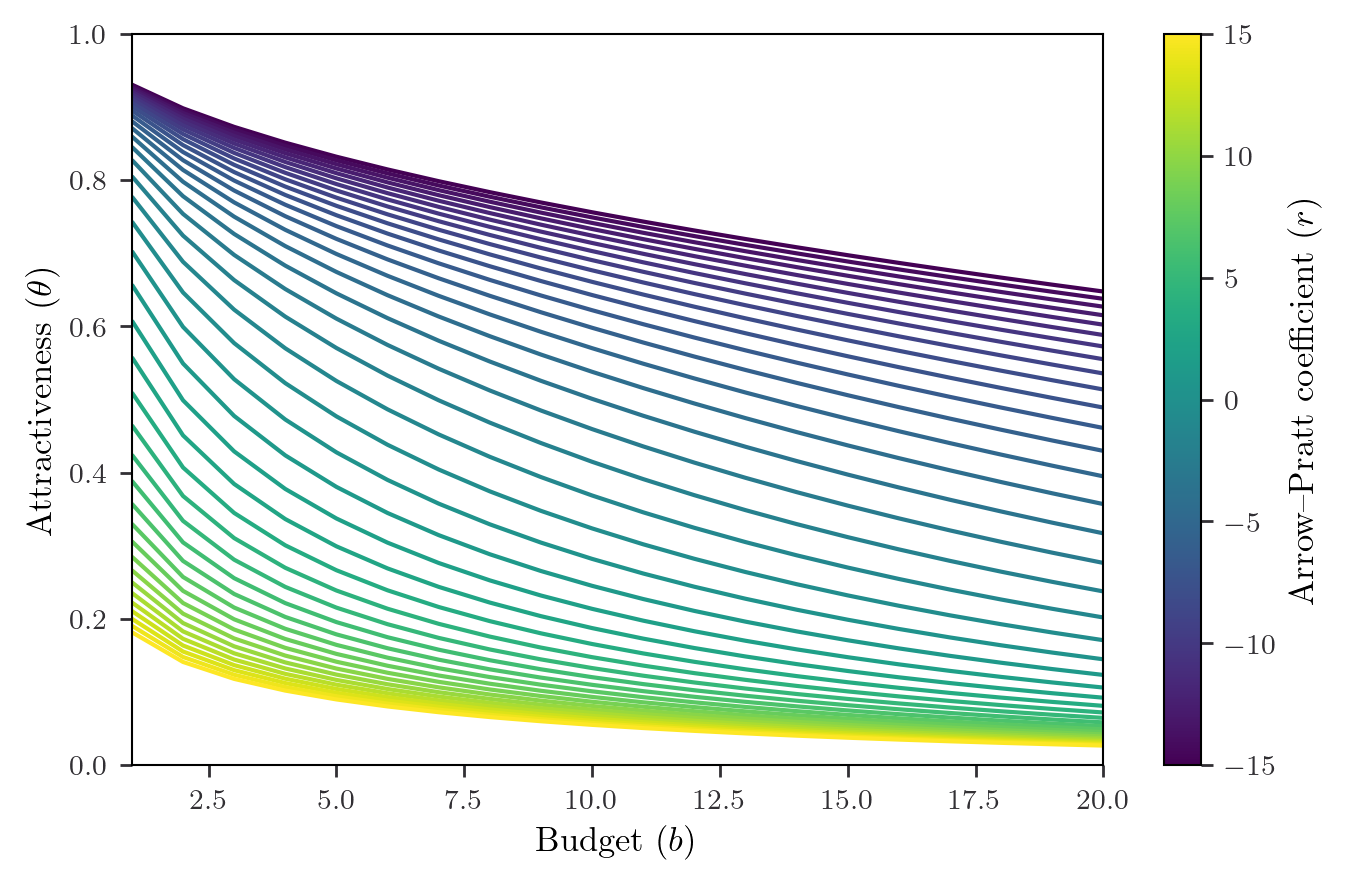

In [10]:
# Resetting exogenous parameters
reset_exog_params()

# Exponential utility function
def u(x):
    if r !=0: 
        return (1 - np.exp(-r*x))/r
    return x 

cara_vals = np.linspace(-15,15,40)
swiping_rules = []

for cara in cara_vals:
    r = cara
    θ_vals = compute_θ_vals(b0)
    swiping_rules.append(θ_vals) 
        
# Plotting swiping rules
fig, ax = plt.subplots()
ax.set_xlim(1,b0)
ax.set_ylim(0,1)
line_segments = LineCollection([np.column_stack([b_vals, θ_vals]) 
                                for θ_vals in swiping_rules])
line_segments.set_array(np.array(cara_vals))
ax.add_collection(line_segments)
axcb = fig.colorbar(line_segments)
axcb.set_label(r'Arrow–Pratt coefficient ($r$)')    
ax.set(xlabel=r'Budget ($b$)', ylabel=r'Attractiveness ($\theta$)')
#plt.savefig('../../figures/risk-cs.png', bbox_inches='tight')
plt.show()

## Comparative statics on the attractiveness distribution moments
Given $\theta_t \sim \text{Beta}(\alpha, \beta)$, the expected value and variance of suggested partner attractiveness is:
$$
 \mathbb{E}[\theta_t]=\frac{\alpha}{\alpha+\beta}
$$ 




$$
 \mathbb{V}[\theta_t]=\frac{\alpha\beta}{(\alpha+\beta)^2(\alpha+\beta+1)}
$$ 
 

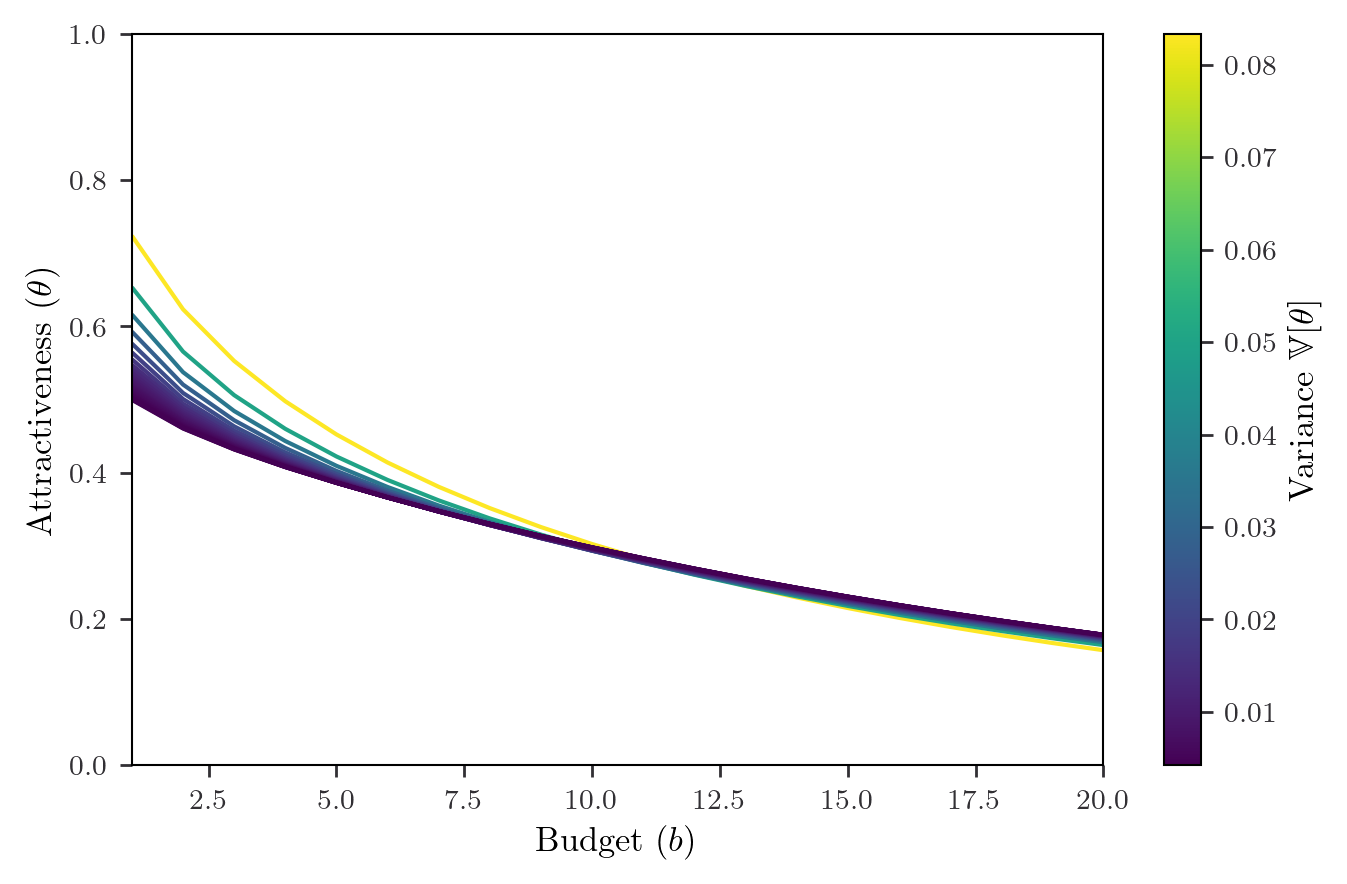

In [11]:
# Resetting exogenous parameters
reset_exog_params()

shape_vals = [(i,i) for i in range(1,30)]
var_vals = [(a*b)/((a+b+1)*(a+b)**2) 
            for a,b in shape_vals]

swiping_rules = []

for s in shape_vals:
    α,β = s
    θ_vals = compute_θ_vals(b0)
    swiping_rules.append(θ_vals) 

# Plotting swiping rules
fig, ax = plt.subplots()
ax.set_xlim(1,b0)
ax.set_ylim(0,1)
line_segments = LineCollection([np.column_stack([b_vals, θ_vals]) 
                                for θ_vals in swiping_rules])
line_segments.set_array(np.array(var_vals))
ax.add_collection(line_segments)
axcb = fig.colorbar(line_segments)
axcb.set_label(r'Variance $\mathbb{V}[\theta]$')  
ax.set(xlabel=r'Budget ($b$)', ylabel=r'Attractiveness ($\theta$)')
#plt.savefig('../../figures/variance-cs.png', bbox_inches='tight') 
plt.show()    